# LangGraph Subgraph 튜토리얼

## 🎯 목적

Subgraph 를 사용해 복잡한 워크플로우를 모듈화하고 재사용 가능한 컴포넌트로 구축하는 방법을 학습합니다.

### 다루는 내용

- Subgraph 개념과 장점  
- Shared/Different State 스키마 설계  
- Persistence(체크포인터)와 상태 전파  
- 스트리밍/모니터링  
- 멀티 에이전트 구성 패턴

### 핵심 원칙

- Subgraph 는 재사용 가능한 워크플로우 컴포넌트입니다.  
- 부모/자식 경계는 명확히, 상태는 필요한 만큼만 공유합니다.

## 📋 목차

1. [환경 설정](#환경-설정)
2. [Part 1: Subgraph 기본 개념](#part-1-subgraph-기본-개념-)
3. [Part 2: Shared State Schemas](#part-2-shared-state-schemas-)
4. [Part 3: Different State Schemas](#part-3-different-state-schemas-)
5. [Part 4: Persistence와 메모리 관리](#part-4-persistence와-메모리-관리-)
6. [Part 5: Subgraph State 모니터링](#part-5-subgraph-state-모니터링-)
7. [Part 6: Stream Outputs](#part-6-stream-outputs-)
8. [Part 7: 실전 - 멀티 에이전트 시스템](#part-7-실전---멀티-에이전트-시스템-)
9. [마무리](#-축하합니다)

## 환경 설정 🛠️

실습에 필요한 최소 설정만 진행합니다. 환경변수로 키를 관리하고, 실행 추적은 선택적으로 활성화하세요.

In [28]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv(override=True)

True

In [29]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Tutorial


---

# Part 1: Subgraph 기본 개념 🎯

## 1.1 서브그래프란?

서브그래프(Subgraph)는 부모 그래프 내부에서 독립적으로 동작하는 하위 그래프입니다. 복잡한 워크플로우를 모듈 단위로 분리하고 재사용하기 위한 핵심 개념입니다.

### 장점
- **🧩 모듈화**: 복잡도를 줄이고 책임을 분리
- **♻️ 재사용**: 동일 로직을 여러 그래프에서 활용
- **🔒 캡슐화**: 내부 구현을 감추고 인터페이스만 노출
- **🤖 멀티 에이전트**: 에이전트를 서브그래프로 명확히 분리

### 부모-자식 상태 소통 패턴
- **Shared State**: 동일 키를 공유하며 읽기/쓰기  
- **Different State**: 각자 다른 스키마를 쓰고 변환을 통해 교환

언제 쓰나? 복잡한 로직 분리, 재사용, 팀 개발, 에이전트 협업이 필요할 때 적합합니다.

In [31]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_teddynote.graphs import visualize_graph


# 🎯 간단한 서브그래프 예제 - 메시지 처리 시스템
class SimpleState(TypedDict):
    """간단한 메시지 상태"""

    message: str
    step_count: int


# 📦 서브그래프 정의 - 메시지 가공 처리기
def create_message_processor():
    """메시지를 가공하는 서브그래프를 생성합니다"""
    subgraph_builder = StateGraph(SimpleState)

    def clean_message(state: SimpleState):
        """메시지 정리"""
        cleaned = state["message"].strip().upper()
        return {"message": cleaned, "step_count": state.get("step_count", 0) + 1}

    def add_emoji(state: SimpleState):
        """이모지 추가"""
        return {
            "message": f"✨ {state['message']} ✨",
            "step_count": state.get("step_count", 0) + 1,
        }

    # 노드와 엣지 추가
    subgraph_builder.add_node("clean", clean_message)
    subgraph_builder.add_node("emoji", add_emoji)
    subgraph_builder.add_edge(START, "clean")
    subgraph_builder.add_edge("clean", "emoji")
    subgraph_builder.add_edge("emoji", END)

    return subgraph_builder.compile()


# 🏗️ 부모 그래프 정의 - 메인 워크플로우
parent_builder = StateGraph(SimpleState)


def prepare_message(state: SimpleState):
    """메시지 준비 단계"""
    return {"message": f"[준비됨] {state['message']}", "step_count": 1}


def finalize_message(state: SimpleState):
    """메시지 최종화 단계"""
    return {
        "message": f"{state['message']} [완료!]",
        "step_count": state.get("step_count", 0) + 1,
    }


# 노드 추가
parent_builder.add_node("prepare", prepare_message)
parent_builder.add_node(
    "processor", create_message_processor()
)  # 🎯 서브그래프를 노드로 추가!
parent_builder.add_node("finalize", finalize_message)

# 엣지 연결
parent_builder.add_edge(START, "prepare")
parent_builder.add_edge("prepare", "processor")
parent_builder.add_edge("processor", "finalize")
parent_builder.add_edge("finalize", END)

# 그래프 컴파일
simple_graph = parent_builder.compile()

그래프를 시각화 합니다.

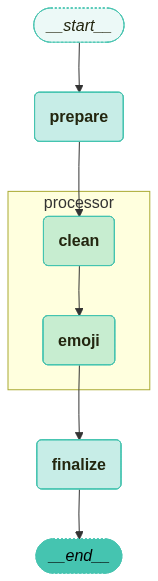

In [33]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(simple_graph, xray=True)

---

# Part 2: Shared State Schemas 🔗

## 2.1 공유 상태 스키마란?

부모 그래프와 서브그래프가 **같은 상태 키를 공유**하며 읽고/쓰는 방식입니다.

### 특징
- **동일 키 접근**: `task_log`, `project_status` 등 공용 키 접근  
- **프라이빗 키 허용**: 서브그래프 내부 전용 키 병행 사용 가능  
- **간단한 소통**: 별도의 변환 없이 즉시 협업  
- **실시간 공유**: 한 곳 업데이트가 전체에 반영

### 적합한 상황
- 팀 협업 시스템, 멀티 에이전트 대화, 단계별 진행상황 추적

In [34]:
from typing import List
from operator import add
from typing import Annotated


# 🔗 공유 상태 스키마 예제 - 팀 작업 관리 시스템
class TeamWorkState(TypedDict):
    """팀 작업 관리를 위한 공유 상태"""

    project_name: str  # 부모와 서브그래프가 공유하는 키
    task_log: Annotated[List[str], add]  # 작업 로그 (누적)
    status: str  # 현재 상태


class DeveloperState(TypedDict):
    """개발자 팀 서브그래프의 상태 (일부 프라이빗 키 포함)"""

    project_name: str  # 부모와 공유
    task_log: Annotated[List[str], add]  # 부모와 공유
    status: str  # 부모와 공유
    dev_notes: str  # 🔒 개발자만 접근 가능한 프라이빗 키
    code_quality: int  # 🔒 코드 품질 점수


# 📦 개발자 팀 서브그래프 생성
def create_developer_team():
    """개발자 팀의 작업 프로세스를 처리하는 서브그래프"""
    builder = StateGraph(DeveloperState)

    def analyze_requirements(state: DeveloperState):
        """요구사항 분석"""
        return {
            "dev_notes": f"요구사항 분석 완료: {state['project_name']}",
            "task_log": ["[개발팀] 요구사항 분석 단계"],
            "code_quality": 85,
        }

    def implement_feature(state: DeveloperState):
        """기능 구현"""
        # 프라이빗 정보를 활용하여 공유 상태 업데이트
        quality_msg = "우수" if state["code_quality"] >= 80 else "보통"
        return {
            "status": f"구현 완료 (품질: {quality_msg})",
            "task_log": [f"[개발팀] 기능 구현 완료 - {state['dev_notes'][:20]}..."],
            "code_quality": state["code_quality"] + 5,  # 품질 개선
        }

    def code_review(state: DeveloperState):
        """코드 리뷰"""
        return {
            "dev_notes": state["dev_notes"] + " | 코드 리뷰 완료",
            "task_log": ["[개발팀] 코드 리뷰 및 최종 검토 완료"],
            "status": f"개발 완료 - 최종 품질: {state['code_quality']}/100",
        }

    # 노드와 엣지 추가
    builder.add_node("analyze", analyze_requirements)
    builder.add_node("implement", implement_feature)
    builder.add_node("review", code_review)

    builder.add_edge(START, "analyze")
    builder.add_edge("analyze", "implement")
    builder.add_edge("implement", "review")
    builder.add_edge("review", END)

    return builder.compile()


# 🏗️ 메인 프로젝트 관리 그래프
project_builder = StateGraph(TeamWorkState)


def initialize_project(state: TeamWorkState):
    """프로젝트 초기화"""
    return {
        "project_name": f"프로젝트: {state['project_name']}",
        "task_log": ["[PM] 프로젝트 초기화 완료"],
        "status": "시작됨",
    }


def project_review(state: TeamWorkState):
    """프로젝트 최종 검토"""
    task_count = len(state["task_log"])
    return {
        "task_log": [f"[PM] 프로젝트 완료 - 총 {task_count}개 작업 수행"],
        "status": "최종 승인됨",
    }


# 노드 추가
project_builder.add_node("initialize", initialize_project)
project_builder.add_node(
    "dev_team", create_developer_team()
)  # 🎯 서브그래프를 노드로 추가
project_builder.add_node("final_review", project_review)

# 엣지 연결
project_builder.add_edge(START, "initialize")
project_builder.add_edge("initialize", "dev_team")
project_builder.add_edge("dev_team", "final_review")
project_builder.add_edge("final_review", END)

# 컴파일
shared_state_graph = project_builder.compile()

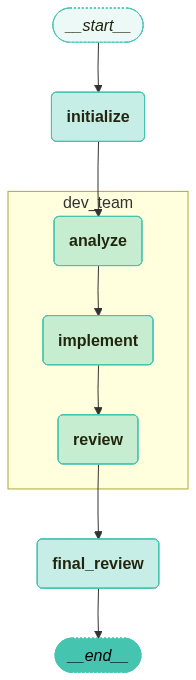

In [35]:
visualize_graph(shared_state_graph, xray=True)

---

# Part 3: Different State Schemas 🔄

## 3.1 독립 상태 스키마란?

부모 그래프와 서브그래프가 **서로 다른 상태 스키마**를 사용하고, 변환을 통해 데이터를 교환하는 방식입니다.

### 핵심 장점
- **완전 캡슐화**: 내부 구현을 외부로부터 분리  
- **독립 진화**: 서로의 변경에 영향 최소화  
- **도메인 최적화**: 역할에 맞는 데이터 구조 사용  
- **보안/추상화**: 인터페이스만 노출

### 상태 변환 흐름
1) 부모 → 서브그래프 입력 변환  
2) 서브그래프 처리  
3) 서브그래프 → 부모 출력 변환

### 적합한 상황
- 시스템 통합, 마이크로서비스, 레거시 연동, 도메인 분리

In [36]:
# 부모 그래프의 상태 (고객 관점)
class CustomerOrderState(TypedDict):
    """고객 주문 상태"""

    customer_name: str
    product_name: str
    order_summary: str


# 서브그래프의 완전히 다른 상태 (창고 관점)
class WarehouseState(TypedDict):
    """창고 처리 상태 - 고객 상태와 완전히 다른 구조"""

    item_code: str
    inventory_check: bool
    processing_steps: List[str]
    warehouse_status: str


# 📦 창고 처리 서브그래프 생성
def create_warehouse_system():
    """창고 처리 로직을 담은 서브그래프 (독립적인 상태 구조)"""
    builder = StateGraph(WarehouseState)

    def check_inventory(state: WarehouseState):
        """재고 확인"""
        # 창고만의 로직으로 재고 확인
        return {
            "inventory_check": True,
            "processing_steps": ["재고 확인 완료"],
            "warehouse_status": f"{state['item_code']} 재고 있음",
        }

    def prepare_shipment(state: WarehouseState):
        """배송 준비"""
        return {
            "processing_steps": state["processing_steps"] + ["포장 준비 완료"],
            "warehouse_status": f"{state['item_code']} 배송 준비됨",
        }

    def update_system(state: WarehouseState):
        """시스템 업데이트"""
        total_steps = len(state["processing_steps"]) + 1
        return {
            "processing_steps": state["processing_steps"] + ["시스템 업데이트 완료"],
            "warehouse_status": f"✅ 처리 완료 (총 {total_steps}단계)",
        }

    # 노드와 엣지 구성
    builder.add_node("inventory", check_inventory)
    builder.add_node("prepare", prepare_shipment)
    builder.add_node("update", update_system)

    builder.add_edge(START, "inventory")
    builder.add_edge("inventory", "prepare")
    builder.add_edge("prepare", "update")
    builder.add_edge("update", END)

    return builder.compile()


# 🏪 메인 주문 처리 그래프
order_builder = StateGraph(CustomerOrderState)


def receive_order(state: CustomerOrderState):
    """주문 접수"""
    return {
        "customer_name": f"고객: {state['customer_name']}",
        "product_name": f"상품: {state['product_name']}",
        "order_summary": "주문 접수됨",
    }


def process_with_warehouse(state: CustomerOrderState):
    """창고 시스템과 연동 (상태 변환 포함)"""

    # 🔄 1. 고객 상태 → 창고 상태로 변환
    warehouse_input = {
        "item_code": f"ITEM_{state['product_name'].replace('상품: ', '').replace(' ', '_').upper()}",
        "inventory_check": False,
        "processing_steps": [],
        "warehouse_status": "대기중",
    }

    # 🏭 2. 창고 서브그래프 실행
    warehouse = create_warehouse_system()
    warehouse_result = warehouse.invoke(warehouse_input)

    # 🔄 3. 창고 결과 → 고객 상태로 역변환
    success = "완료" in warehouse_result["warehouse_status"]
    status = "처리 완료" if success else "처리 실패"

    return {"order_summary": f"{status} - {warehouse_result['warehouse_status']}"}


def finalize_order(state: CustomerOrderState):
    """주문 최종 처리"""
    return {"order_summary": f"{state['order_summary']} | 고객 통지 완료"}


# 노드 추가
order_builder.add_node("receive", receive_order)
order_builder.add_node("warehouse_process", process_with_warehouse)
order_builder.add_node("finalize", finalize_order)

# 엣지 연결
order_builder.add_edge(START, "receive")
order_builder.add_edge("receive", "warehouse_process")
order_builder.add_edge("warehouse_process", "finalize")
order_builder.add_edge("finalize", END)

# 컴파일
different_state_graph = order_builder.compile()

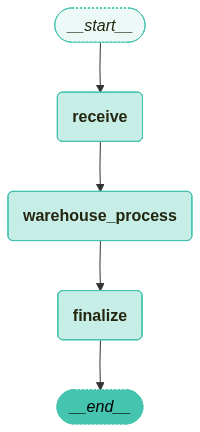

In [37]:
visualize_graph(different_state_graph, xray=True)

In [38]:
# 부모 그래프의 상태
class ParentState(TypedDict):
    """Parent graph state"""

    user_input: str
    final_output: str


# 서브그래프의 완전히 다른 상태
class SubgraphState(TypedDict):
    """Subgraph state - completely different from parent"""

    task_description: str
    processing_steps: List[str]
    result: str


# 서브그래프 생성
def create_different_subgraph():
    """Create subgraph with different state schema"""
    builder = StateGraph(SubgraphState)

    def analyze_task(state: SubgraphState):
        # 작업 분석
        return {
            "processing_steps": ["작업 분석 완료"],
            "result": f"분석: {state['task_description']}",
        }

    def process_task(state: SubgraphState):
        # 작업 처리
        return {
            "processing_steps": state["processing_steps"] + ["작업 처리 완료"],
            "result": state["result"] + " → 처리됨",
        }

    def finalize_task(state: SubgraphState):
        # 작업 완료
        return {
            "processing_steps": state["processing_steps"] + ["최종화 완료"],
            "result": f"✅ {state['result']} (단계: {len(state['processing_steps']) + 1})",
        }

    # 노드와 엣지 구성
    builder.add_node("analyze", analyze_task)
    builder.add_node("process", process_task)
    builder.add_node("finalize", finalize_task)

    builder.add_edge(START, "analyze")
    builder.add_edge("analyze", "process")
    builder.add_edge("process", "finalize")
    builder.add_edge("finalize", END)

    return builder.compile()


# 부모 그래프 생성
parent_builder = StateGraph(ParentState)


def prepare_input(state: ParentState):
    # 사용자 입력 준비
    return {"user_input": f"[준비됨] {state['user_input']}"}


def call_subgraph_with_transform(state: ParentState):
    """Call subgraph with state transformation"""
    # 1. 부모 상태 → 서브그래프 상태로 변환
    subgraph_input = {
        "task_description": state["user_input"],  # 변환 매핑
        "processing_steps": [],
        "result": "",
    }

    # 2. 서브그래프 실행
    subgraph = create_different_subgraph()
    subgraph_output = subgraph.invoke(subgraph_input)

    # 3. 서브그래프 결과 → 부모 상태로 변환
    return {
        "final_output": subgraph_output["result"],  # 역변환 매핑
    }


# 노드 추가
parent_builder.add_node("prepare", prepare_input)
parent_builder.add_node("subgraph_caller", call_subgraph_with_transform)

# 엣지 연결
parent_builder.add_edge(START, "prepare")
parent_builder.add_edge("prepare", "subgraph_caller")
parent_builder.add_edge("subgraph_caller", END)

# 컴파일 및 실행
different_graph = parent_builder.compile()

result = different_graph.invoke({"user_input": "복잡한 작업 요청", "final_output": ""})

print("\n🔄 Different State Schema 실행 결과:")
print(f"\n입력: {result['user_input']}")
print(f"출력: {result['final_output']}")


🔄 Different State Schema 실행 결과:

입력: [준비됨] 복잡한 작업 요청
출력: ✅ 분석: [준비됨] 복잡한 작업 요청 → 처리됨 (단계: 3)


## 3.2 다층 서브그래프 (Nested Subgraphs)

서브그래프 내부에 서브그래프를 포함해 계층 구조를 구성할 수 있습니다. 복잡한 시스템을 단계적으로 분리해 설계/테스트/재사용성을 높입니다.

In [ ]:
# 손자 그래프 상태
class GrandchildState(TypedDict):
    """Grandchild graph state"""

    detail_info: str


# 자식 그래프 상태
class ChildState(TypedDict):
    """Child graph state"""

    child_data: str


# 부모 그래프 상태
class NestedParentState(TypedDict):
    """Parent graph state"""

    main_data: str
    hierarchy_path: List[str]


# 손자 그래프 생성
def create_grandchild_graph():
    """Create grandchild graph"""
    builder = StateGraph(GrandchildState)

    def grandchild_process(state: GrandchildState):
        # 손자 레벨 처리
        return {"detail_info": state["detail_info"] + " [손자 처리]"}

    builder.add_node("gc_process", grandchild_process)
    builder.add_edge(START, "gc_process")
    builder.add_edge("gc_process", END)

    return builder.compile()


# 자식 그래프 생성 (손자 그래프 포함)
def create_child_graph():
    """Create child graph with grandchild"""
    builder = StateGraph(ChildState)

    def child_process(state: ChildState):
        # 자식 레벨 처리
        return {"child_data": state["child_data"] + " [자식 처리]"}

    def call_grandchild(state: ChildState):
        # 손자 그래프 호출 (상태 변환 포함)
        grandchild = create_grandchild_graph()
        gc_input = {"detail_info": state["child_data"]}
        gc_output = grandchild.invoke(gc_input)
        return {"child_data": gc_output["detail_info"]}

    builder.add_node("c_process", child_process)
    builder.add_node("call_gc", call_grandchild)

    builder.add_edge(START, "c_process")
    builder.add_edge("c_process", "call_gc")
    builder.add_edge("call_gc", END)

    return builder.compile()


# 부모 그래프 생성 (자식 그래프 포함)
nested_parent_builder = StateGraph(NestedParentState)


def parent_process(state: NestedParentState):
    # 부모 레벨 처리
    return {
        "main_data": state["main_data"] + " [부모 처리]",
        "hierarchy_path": ["부모"],
    }


def call_child_graph(state: NestedParentState):
    # 자식 그래프 호출 (상태 변환 포함)
    child = create_child_graph()
    child_input = {"child_data": state["main_data"]}
    child_output = child.invoke(child_input)

    return {
        "main_data": child_output["child_data"],
        "hierarchy_path": state["hierarchy_path"] + ["자식", "손자"],
    }


# 노드 추가
nested_parent_builder.add_node("p_process", parent_process)
nested_parent_builder.add_node("call_child", call_child_graph)

# 엣지 연결
nested_parent_builder.add_edge(START, "p_process")
nested_parent_builder.add_edge("p_process", "call_child")
nested_parent_builder.add_edge("call_child", END)

# 컴파일 및 실행
nested_graph = nested_parent_builder.compile()

result = nested_graph.invoke({"main_data": "초기 데이터", "hierarchy_path": []})

print("\n🏗️ 다층 서브그래프 실행 결과:")
print(f"\n최종 데이터: {result['main_data']}")
print(f"계층 경로: {' → '.join(result['hierarchy_path'])}")

---

# Part 4: Persistence와 메모리 관리 💾

## 4.1 체크포인터 전파

부모 그래프에 설정한 **체크포인터**는 기본적으로 서브그래프에도 전파되어 동일한 실행 이력을 공유합니다. 필요 시 서브그래프에 별도의 체크포인터를 지정해 독립적으로 관리할 수 있습니다.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver


class PersistentState(TypedDict):
    """State for persistence example"""

    counter: int
    history: List[str]


# 서브그래프 생성
def create_persistent_subgraph():
    """Create subgraph with persistence capability"""
    builder = StateGraph(PersistentState)

    def increment_counter(state: PersistentState):
        # 카운터 증가
        return {
            "counter": state["counter"] + 1,
            "history": state["history"]
            + [f"서브그래프: 카운터 {state['counter']} → {state['counter'] + 1}"],
        }

    builder.add_node("increment", increment_counter)
    builder.add_edge(START, "increment")
    builder.add_edge("increment", END)

    # 서브그래프에 독립적인 메모리를 원한다면:
    # return builder.compile(checkpointer=True)

    # 부모의 체크포인터를 공유하려면:
    return builder.compile()


# 부모 그래프 생성
persistent_parent_builder = StateGraph(PersistentState)


def parent_increment(state: PersistentState):
    # 부모에서도 카운터 증가
    return {
        "counter": state["counter"] + 10,
        "history": state["history"] + [f"부모: 카운터 +10"],
    }


# 노드 추가
persistent_parent_builder.add_node("parent_inc", parent_increment)
persistent_parent_builder.add_node("subgraph", create_persistent_subgraph())

# 엣지 연결
persistent_parent_builder.add_edge(START, "parent_inc")
persistent_parent_builder.add_edge("parent_inc", "subgraph")
persistent_parent_builder.add_edge("subgraph", END)

# 체크포인터와 함께 컴파일
memory = MemorySaver()
persistent_graph = persistent_parent_builder.compile(checkpointer=memory)

# 첫 번째 실행
config = {"configurable": {"thread_id": "test-thread-1"}}
result1 = persistent_graph.invoke({"counter": 0, "history": []}, config=config)

print("\n💾 Persistence 테스트:")
print("\n첫 번째 실행:")
print(f"  카운터: {result1['counter']}")
print(f"  히스토리: {result1['history']}")

# 두 번째 실행 (같은 thread_id로 상태 복원)
result2 = persistent_graph.invoke(
    None, config=config  # None을 전달하면 이전 상태에서 계속
)

print("\n두 번째 실행 (상태 복원):")
print(f"  카운터: {result2['counter']}")
print(f"  히스토리 길이: {len(result2['history'])}개")

---

# Part 5: Subgraph State 모니터링 🔍

## 5.1 중단된 서브그래프 상태 보기

서브그래프가 **interrupt** 로 중단된 상태에서 내부 상태를 조회해 흐름과 다음 실행 노드를 확인할 수 있습니다. 디버깅과 운영 모니터링에 유용합니다.

⚠️ 중단 상태에서만 조회 가능합니다.

In [ ]:
from langgraph.types import interrupt, Command
from typing import Literal


class InterruptState(TypedDict):
    """State for interrupt example"""

    value: str
    approved: bool


# 중단이 있는 서브그래프
def create_interruptible_subgraph():
    """Create subgraph with interrupt"""
    builder = StateGraph(InterruptState)

    def request_approval(state: InterruptState):
        # 사용자 승인 요청 (중단)
        user_input = interrupt("이 작업을 승인하시겠습니까? (yes/no)")
        return {
            "value": state["value"] + f" - 사용자 응답: {user_input}",
            "approved": user_input.lower() == "yes",
        }

    builder.add_node("request", request_approval)
    builder.add_edge(START, "request")
    builder.add_edge("request", END)

    return builder.compile()


# 부모 그래프
interrupt_parent_builder = StateGraph(InterruptState)


def prepare_request(state: InterruptState):
    # 요청 준비
    return {"value": "중요한 작업"}


# 노드 추가
interrupt_parent_builder.add_node("prepare", prepare_request)
interrupt_parent_builder.add_node("subgraph", create_interruptible_subgraph())

# 엣지 연결
interrupt_parent_builder.add_edge(START, "prepare")
interrupt_parent_builder.add_edge("prepare", "subgraph")
interrupt_parent_builder.add_edge("subgraph", END)

# 체크포인터와 함께 컴파일
memory = MemorySaver()
interrupt_graph = interrupt_parent_builder.compile(checkpointer=memory)

# 실행 (중단될 것임)
config = {"configurable": {"thread_id": "interrupt-test"}}

print("\n🔍 Interrupt 모니터링 테스트:")
print("\n1. 첫 실행 (중단됨):")

try:
    result = interrupt_graph.invoke({"value": "", "approved": False}, config=config)
except Exception as e:
    print(f"  중단됨: {e}")

# 상태 조회
parent_state = interrupt_graph.get_state(config)
print(f"\n2. 부모 그래프 상태:")
print(f"  다음 실행할 노드: {parent_state.next}")

# 서브그래프 상태 조회 (중단된 상태에서만 가능)
full_state = interrupt_graph.get_state(config, subgraphs=True)
if full_state.tasks:
    subgraph_state = full_state.tasks[0].state
    print(f"\n3. 서브그래프 상태:")
    print(f"  서브그래프 다음 노드: {subgraph_state.next if subgraph_state else 'N/A'}")

# 재개 (사용자 응답 제공)
print("\n4. 재개 (승인):")
result = interrupt_graph.invoke(Command(resume="yes"), config=config)

print(f"  최종 결과: {result['value']}")
print(f"  승인 여부: {result['approved']}")

---

# Part 7: 실전 - 멀티 에이전트 시스템 🤖

## 7.1 실제 업무에 적용하는 멀티 에이전트 시스템

서브그래프로 각 역할을 분리한 **고객 지원 시스템**을 구현합니다.

### 구조 개요
- **분류 에이전트**: 문의 카테고리 분류  
- **솔루션 에이전트**: 해결책 제안  
- **평가 에이전트**: 만족도 측정

### 서브그래프 분리의 이점
- 전문화, 독립 개발/테스트, 손쉬운 확장/재사용

### 공유 상태로 협력
- `messages`, `issue_category`, `solution_provided`, `satisfaction_score`

### 적용 사례
- 고객센터 자동화, 의료 상담, 교육 튜터링, 이커머스 CS

In [ ]:
# 🤖 실전 멀티 에이전트 시스템 - 고객 지원 센터
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langgraph.checkpoint.memory import InMemorySaver


# gpt-4.1 모델 사용
llm = ChatOpenAI(model="gpt-4.1", temperature=0.3)


# 🌐 공유 메시지 상태
class SupportState(TypedDict):
    """고객 지원 시스템 공유 상태"""

    messages: Annotated[List[AnyMessage], add_messages]
    customer_issue: str
    issue_category: str
    solution_provided: bool
    satisfaction_score: int


# 🔍 1단계 에이전트: 문제 분류기
def create_classifier_agent():
    """고객 문제를 분류하는 에이전트"""
    builder = StateGraph(SupportState)

    def classify_issue(state: SupportState):
        """고객 문제 분류"""
        customer_message = state["customer_issue"]

        # 간단한 키워드 기반 분류 (실제로는 LLM 사용 가능)
        if any(word in customer_message.lower() for word in ["결제", "환불", "카드"]):
            category = "결제문제"
        elif any(
            word in customer_message.lower() for word in ["로그인", "계정", "비밀번호"]
        ):
            category = "계정문제"
        elif any(word in customer_message.lower() for word in ["배송", "주문", "택배"]):
            category = "배송문제"
        else:
            category = "일반문의"

        return {
            "issue_category": category,
            "messages": [AIMessage(content=f"🔍 문제 분류 완료: {category}")],
        }

    builder.add_node("classify", classify_issue)
    builder.add_edge(START, "classify")
    builder.add_edge("classify", END)

    return builder.compile()


# 💡 2단계 에이전트: 솔루션 제공기
def create_solution_agent():
    """문제 해결책을 제공하는 에이전트"""
    builder = StateGraph(SupportState)

    def provide_solution(state: SupportState):
        """카테고리별 솔루션 제공"""
        category = state["issue_category"]
        customer_issue = state["customer_issue"]

        # 카테고리별 솔루션 템플릿
        solutions = {
            "결제문제": "💳 결제 문제 해결 방법:\n1. 카드 정보 재확인\n2. 다른 결제 수단 시도\n3. 은행 문의",
            "계정문제": "🔐 계정 문제 해결 방법:\n1. 비밀번호 재설정\n2. 이메일 인증 확인\n3. 고객센터 문의",
            "배송문제": "📦 배송 문제 해결 방법:\n1. 주문번호로 배송 추적\n2. 배송업체 직접 문의\n3. 교환/환불 신청",
            "일반문의": "ℹ️ 일반 문의 답변:\n상세한 도움이 필요하시면 고객센터(1588-0000)로 연락 주세요.",
        }

        solution = solutions.get(
            category, "죄송합니다. 전문 상담원에게 연결해드리겠습니다."
        )

        return {
            "solution_provided": True,
            "messages": [AIMessage(content=f"💡 해결책 제안:\n{solution}")],
        }

    builder.add_node("solve", provide_solution)
    builder.add_edge(START, "solve")
    builder.add_edge("solve", END)

    return builder.compile()


# 📊 3단계 에이전트: 만족도 평가기
def create_feedback_agent():
    """고객 만족도를 평가하는 에이전트"""
    builder = StateGraph(SupportState)

    def evaluate_satisfaction(state: SupportState):
        """만족도 평가"""
        import random

        # 실제로는 고객 피드백을 받지만, 여기서는 시뮬레이션
        category = state["issue_category"]

        # 카테고리별 만족도 차이 시뮬레이션
        base_scores = {"결제문제": 85, "계정문제": 90, "배송문제": 75, "일반문의": 80}

        base_score = base_scores.get(category, 80)
        satisfaction = base_score + random.randint(-10, 10)
        satisfaction = max(0, min(100, satisfaction))  # 0-100 범위 제한

        feedback_msg = (
            "😊 우수"
            if satisfaction >= 90
            else "🙂 양호" if satisfaction >= 70 else "😐 보통"
        )

        return {
            "satisfaction_score": satisfaction,
            "messages": [
                AIMessage(
                    content=f"📊 고객 만족도: {satisfaction}/100 ({feedback_msg})"
                )
            ],
        }

    builder.add_node("evaluate", evaluate_satisfaction)
    builder.add_edge(START, "evaluate")
    builder.add_edge("evaluate", END)

    return builder.compile()


# 🎯 메인 고객 지원 조정자 시스템
support_builder = StateGraph(SupportState)


def initialize_support(state: SupportState):
    """고객 지원 시작"""
    return {
        "messages": [AIMessage(content="🎧 고객 지원 시스템을 시작합니다...")],
        "solution_provided": False,
        "satisfaction_score": 0,
    }


def finalize_support(state: SupportState):
    """지원 종료"""
    avg_satisfaction = state["satisfaction_score"]
    status = "성공적" if avg_satisfaction >= 80 else "개선 필요"

    return {
        "messages": [
            AIMessage(content=f"✅ 고객 지원 완료 - {status} ({avg_satisfaction}/100)")
        ]
    }


# 노드 추가 - 각 에이전트를 서브그래프로 추가
support_builder.add_node("initialize", initialize_support)
support_builder.add_node("classifier", create_classifier_agent())  # 🤖 분류 에이전트
support_builder.add_node(
    "solution_provider", create_solution_agent()
)  # 🤖 솔루션 에이전트
support_builder.add_node(
    "feedback_evaluator", create_feedback_agent()
)  # 🤖 평가 에이전트
support_builder.add_node("finalize", finalize_support)

# 순차적 처리 흐름
support_builder.add_edge(START, "initialize")
support_builder.add_edge("initialize", "classifier")
support_builder.add_edge("classifier", "solution_provider")
support_builder.add_edge("solution_provider", "feedback_evaluator")
support_builder.add_edge("feedback_evaluator", "finalize")
support_builder.add_edge("finalize", END)

# 컴파일
multi_agent_system = support_builder.compile(checkpointer=InMemorySaver())

print("✅ 실전 멀티 에이전트 고객 지원 시스템 생성 완료!")

In [ ]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
print("📊 멀티 에이전트 고객 지원 시스템 구조:")
visualize_graph(multi_agent_system)

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, random_uuid

# 🚀 다양한 고객 문의 시나리오 테스트
test_cases = [
    "신용카드 결제가 안 되는데 도와주세요",
    "로그인이 안 되고 비밀번호를 잊어버렸어요",
    "주문한 상품이 언제 도착하나요?",
    "서비스 이용 방법을 알고 싶습니다",
]

print("\n🎧 고객 지원 시스템 테스트:")
print("=" * 60)

for i, issue in enumerate(test_cases, 1):
    print(f"\n📞 고객 문의 #{i}: {issue}")
    print("-" * 40)
    config = RunnableConfig(configurable={"thread_id": random_uuid()})

    invoke_graph(
        multi_agent_system,
        inputs={
            "customer_issue": issue,
            "messages": [],
            "issue_category": "",
            "solution_provided": False,
            "satisfaction_score": 0,
        },
        config=config,
    )

    result = multi_agent_system.get_state(config).values

    print(f"📋 분류: {result['issue_category']}")
    print(f"💡 해결책 제공: {'✅' if result['solution_provided'] else '❌'}")
    print(f"📊 만족도: {result['satisfaction_score']}/100")

    # 메시지 중 솔루션 부분만 표시
    for msg in result["messages"]:
        if "해결책 제안" in msg.content:
            solution_lines = msg.content.split("\n")[1:4]  # 첫 3줄만
            for line in solution_lines:
                if line.strip():
                    print(f"   {line}")
            break

print(f"\n🎯 멀티 에이전트 시스템의 장점:")
print(f"  🔀 모듈화: 각 에이전트가 독립적인 역할 수행")
print(f"  🔄 확장성: 새로운 에이전트 추가 용이")
print(f"  🎯 전문화: 각 도메인별 최적화된 처리")
print(f"  📈 성능: 병렬 처리 및 효율적인 워크플로우")

In [ ]:
multi_agent_system.get_state(config).values

---

# ✅ 마무리: 핵심만 다시 정리

## 핵심 개념
1. **서브그래프**: 모듈화·재사용 가능한 하위 그래프  
2. **공유 상태**: 동일 키 공유로 간단한 협업  
3. **독립 상태**: 변환 기반 통신으로 캡슐화/보안 강화  
4. **멀티 에이전트**: 역할 분리, 서브그래프로 조립

## 실습 범위
- 메시지 처리 서브그래프  
- 팀 작업 관리(Shared State)  
- 주문-창고 연동(Different State)  
- 고객 지원 멀티 에이전트

## 다음 단계
- 상태/리듀서 설계 심화, 예외 처리, 성능 최적화(캐싱/병렬)  
- 조건부/동적 서브그래프, 체크포인팅 운영  
- 마이크로서비스/에이전트 오케스트레이션/프로덕션 운영

## 운영 팁
- 설계: 단일 책임, 느슨한 결합, 높은 응집도  
- 품질: 로깅·시각화·테스트 분리

**필요한 만큼 작게 시작하고, 점진적으로 확장하세요. 🚀**

---

# Part 7: 실전 - 멀티 에이전트 시스템 🤖

## 7.1 전문가 에이전트 시스템

서브그래프를 활용해 역할별 전문가 에이전트를 조합합니다. 각 서브그래프는 단일 책임을 가지며, 조정자 그래프가 라우팅과 최종 검토를 담당합니다.

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages


# 공유 메시지 상태
class AgentState(TypedDict):
    """Shared state for multi-agent system"""

    messages: Annotated[List[AnyMessage], add_messages]
    current_agent: str
    task_type: str
    metadata: dict


# 연구원 에이전트 (서브그래프)
def create_researcher_agent():
    """Create researcher agent subgraph"""
    builder = StateGraph(AgentState)

    def research(state: AgentState):
        # 연구 수행
        last_message = state["messages"][-1]
        research_result = (
            f"📚 연구 결과: '{last_message.content}'에 대한 심층 분석 완료"
        )

        return {
            "messages": [AIMessage(content=research_result)],
            "metadata": {**state.get("metadata", {}), "research_done": True},
        }

    def validate_research(state: AgentState):
        # 연구 검증
        validation = "✅ 연구 검증: 신뢰도 95%, 출처 확인 완료"
        return {
            "messages": [AIMessage(content=validation)],
            "metadata": {**state.get("metadata", {}), "validated": True},
        }

    builder.add_node("research", research)
    builder.add_node("validate", validate_research)

    builder.add_edge(START, "research")
    builder.add_edge("research", "validate")
    builder.add_edge("validate", END)

    return builder.compile()


# 개발자 에이전트 (서브그래프)
def create_developer_agent():
    """Create developer agent subgraph"""
    builder = StateGraph(AgentState)

    def analyze_requirements(state: AgentState):
        # 요구사항 분석
        last_message = state["messages"][-1]
        analysis = f"💻 요구사항 분석: '{last_message.content}'를 위한 기술 스택 결정"

        return {
            "messages": [AIMessage(content=analysis)],
            "metadata": {
                **state.get("metadata", {}),
                "tech_stack": "Python, LangGraph",
            },
        }

    def generate_code(state: AgentState):
        # 코드 생성
        code = """```python
# 자동 생성된 코드
def solution():
    return "구현 완료"
```"""

        return {
            "messages": [AIMessage(content=f"코드 생성 완료:\n{code}")],
            "metadata": {**state.get("metadata", {}), "code_generated": True},
        }

    builder.add_node("analyze", analyze_requirements)
    builder.add_node("code", generate_code)

    builder.add_edge(START, "analyze")
    builder.add_edge("analyze", "code")
    builder.add_edge("code", END)

    return builder.compile()


# 매니저 에이전트 (서브그래프)
def create_manager_agent():
    """Create manager agent subgraph"""
    builder = StateGraph(AgentState)

    def review_work(state: AgentState):
        # 작업 검토
        messages = state["messages"]
        review = "🎯 매니저 검토: 모든 작업이 성공적으로 완료되었습니다."

        # 작업 요약
        summary = "\n📋 작업 요약:\n"
        for msg in messages[-3:]:
            if isinstance(msg, AIMessage):
                summary += f"  • {msg.content[:50]}...\n"

        return {
            "messages": [AIMessage(content=review + summary)],
            "metadata": {**state.get("metadata", {}), "reviewed": True},
        }

    builder.add_node("review", review_work)
    builder.add_edge(START, "review")
    builder.add_edge("review", END)

    return builder.compile()


# 메인 조정자 그래프
coordinator_builder = StateGraph(AgentState)


def route_task(state: AgentState) -> Literal["researcher", "developer", "manager"]:
    """Route task to appropriate agent"""
    # 작업 유형에 따라 적절한 에이전트로 라우팅
    task_type = state.get("task_type", "")

    if "연구" in task_type or "조사" in task_type:
        return "researcher"
    elif "개발" in task_type or "코드" in task_type:
        return "developer"
    else:
        return "manager"


def classify_task(state: AgentState):
    """Classify the incoming task"""
    # 작업 분류
    last_message = state["messages"][-1]
    content = last_message.content.lower()

    if "연구" in content or "조사" in content:
        task_type = "연구"
    elif "개발" in content or "코드" in content or "구현" in content:
        task_type = "개발"
    else:
        task_type = "관리"

    return {
        "task_type": task_type,
        "messages": [AIMessage(content=f"📌 작업 분류: {task_type} 작업으로 분류됨")],
    }


# 노드 추가
coordinator_builder.add_node("classify", classify_task)
coordinator_builder.add_node("researcher", create_researcher_agent())
coordinator_builder.add_node("developer", create_developer_agent())
coordinator_builder.add_node("manager", create_manager_agent())

# 엣지 추가
coordinator_builder.add_edge(START, "classify")
coordinator_builder.add_conditional_edges(
    "classify",
    route_task,
    {"researcher": "researcher", "developer": "developer", "manager": "manager"},
)

# 모든 에이전트는 매니저로 최종 검토
coordinator_builder.add_edge("researcher", "manager")
coordinator_builder.add_edge("developer", "manager")
coordinator_builder.add_edge("manager", END)

# 컴파일
multi_agent_system = coordinator_builder.compile()

print("\n🤖 멀티 에이전트 시스템 테스트:\n")

# 다양한 작업 테스트
test_tasks = [
    "LangGraph에 대해 연구해주세요",
    "간단한 챗봇 코드를 개발해주세요",
    "프로젝트 진행 상황을 검토해주세요",
]

for task in test_tasks:
    print(f"\n📝 작업: {task}")
    print("=" * 50)

    result = multi_agent_system.invoke(
        {
            "messages": [HumanMessage(content=task)],
            "current_agent": "coordinator",
            "task_type": "",
            "metadata": {},
        }
    )

    # 최종 메시지 출력
    for msg in result["messages"][-3:]:
        if isinstance(msg, AIMessage):
            print(f"\n{msg.content}")

    print(f"\n📊 메타데이터: {result['metadata']}")